<a href="https://colab.research.google.com/github/Vakhranev/MDB/blob/main/%D0%93%D0%B5%D0%B9%D0%BC%D1%81-%D0%A5%D0%B0%D1%83%D1%8D%D0%BB%D0%BB%20%D0%B4%D0%BB%D1%8F%20MTLD%20%D0%B8%20HD-D%20%D0%BF%D0%BE%20%D1%82%D0%BE%D0%BA%D0%B5%D0%BD%D0%B0%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os
import math
import re
import nltk
nltk.download('punkt')
from nltk import word_tokenize
nltk.download('wordnet')
import pandas as pd
from collections import defaultdict
from lexicalrichness import LexicalRichness
import pingouin as pg
import numpy as np

class MetricsCalculator:
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.hd_data = defaultdict(list)
        self.mtld_data = defaultdict(list)
        self.file_names = []

    def preprocess_text(self, text):
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'\n', '', text)
        return text

    def calculate_ttr(self, tokens):
        total_tokens = len(tokens)
        unique_tokens = len(set(tokens))
        ttr = unique_tokens / total_tokens
        return ttr

    def process_files(self, directory):
        cefr_levels = ['A1', 'A2', 'B1', 'B2']

        for cefr_level in cefr_levels:
            cefr_dir = os.path.join(directory, cefr_level)
            if os.path.isdir(cefr_dir):
                for filename in os.listdir(cefr_dir):
                    if filename.endswith(".txt"):
                        filepath = os.path.join(cefr_dir, filename)
                        with open(filepath, "r", encoding="utf-8") as file:
                            text = file.read()
                            preprocessed_text = self.preprocess_text(text)
                            tokens = word_tokenize(preprocessed_text)
                            # Фильтрация на количество токенов (больше или равно 50)
                            if len(tokens) >= 50:
                                lex = LexicalRichness(text)
                                hd = lex.hdd(draws=20)  # Уменьшил количество draws
                                mtld = lex.mtld(threshold=0.72)
                                self.hd_data[cefr_level].append(hd)
                                self.mtld_data[cefr_level].append(mtld)
                                self.file_names.append(filename)

    def calculate_avg_metrics(self):
        avg_hd = {}
        avg_mtld = {}

        for cefr_level, hd_values in self.hd_data.items():
            avg_hd[cefr_level] = sum(hd_values) / len(hd_values)

        for cefr_level, mtld_values in self.mtld_data.items():
            avg_mtld[cefr_level] = sum(mtld_values) / len(mtld_values)

        return avg_hd, avg_mtld

    def save_to_excel(self, output_path):
        data = {
            'File Name': self.file_names,
            'CEFR Level': [],
            'HD-D': [],
            'MTLD': []
        }

        avg_hd, avg_mtld = self.calculate_avg_metrics()

        for cefr_level in avg_hd.keys():
            data['CEFR Level'].extend([cefr_level] * len(self.hd_data[cefr_level]))
            data['HD-D'].extend(self.hd_data[cefr_level])
            data['MTLD'].extend(self.mtld_data[cefr_level])

        df = pd.DataFrame(data)
        df.to_excel(output_path, index=False)

        # Считаем статистики для MTLD
        mean_mtld_all = np.mean(list(avg_mtld.values()))
        sd_mtld_all = np.std(list(avg_mtld.values()))
        std_error_mtld_all = np.std(list(avg_mtld.values())) / np.sqrt(len(avg_mtld))
        ci_mtld_all = pg.compute_bootci(list(avg_mtld.values()), func=np.mean)

        # Считаем статистики для HD-D
        mean_hd_all = np.mean(list(avg_hd.values()))
        sd_hd_all = np.std(list(avg_hd.values()))
        std_error_hd_all = np.std(list(avg_hd.values())) / np.sqrt(len(avg_hd))
        ci_hd_all = pg.compute_bootci(list(avg_hd.values()), func=np.mean)

        # Выводим статистики
        print("Статистики для MTLD:")
        print(f"Mean: {mean_mtld_all}")
        print(f"SD: {sd_mtld_all}")
        print(f"Std. Error: {std_error_mtld_all}")
        print(f"95% CI (confidence interval) (mean): {ci_mtld_all}")

        print("Статистики для HD-D:")
        print(f"Mean: {mean_hd_all}")
        print(f"SD: {sd_hd_all}")
        print(f"Std. Error: {std_error_hd_all}")
        print(f"95% CI (confidence interval) (mean): {ci_hd_all}")

    def calculate_and_print_stats(self, metric_data, metric_name):
        print(f"\n--- {metric_name} ---")
        data = []
        for cefr_level, values in metric_data.items():
            data.extend(list(zip([cefr_level] * len(values), values)))
        df = pd.DataFrame(data, columns=['CEFR Level', metric_name])

        # One-way ANOVA
        anova_result = pg.anova(data=df, dv=metric_name, between='CEFR Level')
        print(f"ANOVA F-statistic ({metric_name}): {anova_result['F'][0]}")
        print(f"ANOVA p-value ({metric_name}): {anova_result['p-unc'][0]}")

        # Games-Howell post hoc test
        games_howell_result = pg.pairwise_gameshowell(data=df, dv=metric_name, between='CEFR Level')
        print(f"\nGames-Howell Test Results for {metric_name}:")
        print(games_howell_result)

if __name__ == "__main__":
    directory_path = "/content/Students_texts"
    output_excel_path = "/content/lexical_metrics_tokens.xlsx"

    metrics_calculator = MetricsCalculator(threshold=0.72)
    metrics_calculator.process_files(directory_path)

    metrics_calculator.calculate_and_print_stats(metrics_calculator.hd_data, 'HD-D')
    metrics_calculator.calculate_and_print_stats(metrics_calculator.mtld_data, 'MTLD')

    avg_hd, avg_mtld = metrics_calculator.calculate_avg_metrics()

    for cefr_level, avg in avg_hd.items():
        print(f"CEFR Level: {cefr_level}, Avg HD-D: {avg:.4f}")

    for cefr_level, avg in avg_mtld.items():
        print(f"CEFR Level: {cefr_level}, Avg MTLD: {avg:.4f}")

    metrics_calculator.save_to_excel(output_excel_path)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



--- HD-D ---
ANOVA F-statistic (HD-D): 78.27438007283395
ANOVA p-value (HD-D): 1.4525175307654612e-45

Games-Howell Test Results for HD-D:
    A   B   mean(A)   mean(B)      diff        se         T          df  \
0  A1  A2  0.864188  0.904047 -0.039860  0.007340 -5.430593   42.408328   
1  A1  B1  0.864188  0.922076 -0.057888  0.007300 -7.929875   41.499495   
2  A1  B2  0.864188  0.929270 -0.065083  0.007557 -8.612614   47.491716   
3  A2  B1  0.904047  0.922076 -0.018029  0.001961 -9.192034  815.623350   
4  A2  B2  0.904047  0.929270 -0.025223  0.002768 -9.113506  236.997696   
5  B1  B2  0.922076  0.929270 -0.007195  0.002660 -2.704433  207.656888   

           pval    hedges  
0  1.475554e-05 -1.262861  
1  4.527449e-09 -1.987232  
2  1.728367e-10 -2.032049  
3  0.000000e+00 -0.632920  
4  0.000000e+00 -0.868496  
5  3.693495e-02 -0.265907  

--- MTLD ---
ANOVA F-statistic (MTLD): 93.35053469235783
ANOVA p-value (MTLD): 2.2524677519462733e-53

Games-Howell Test Results for MTLD

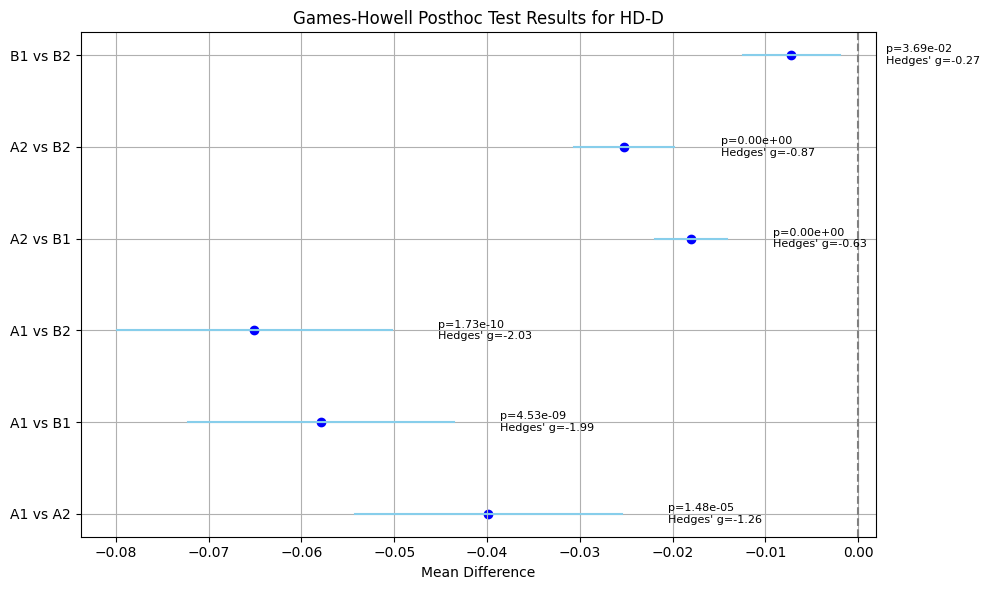

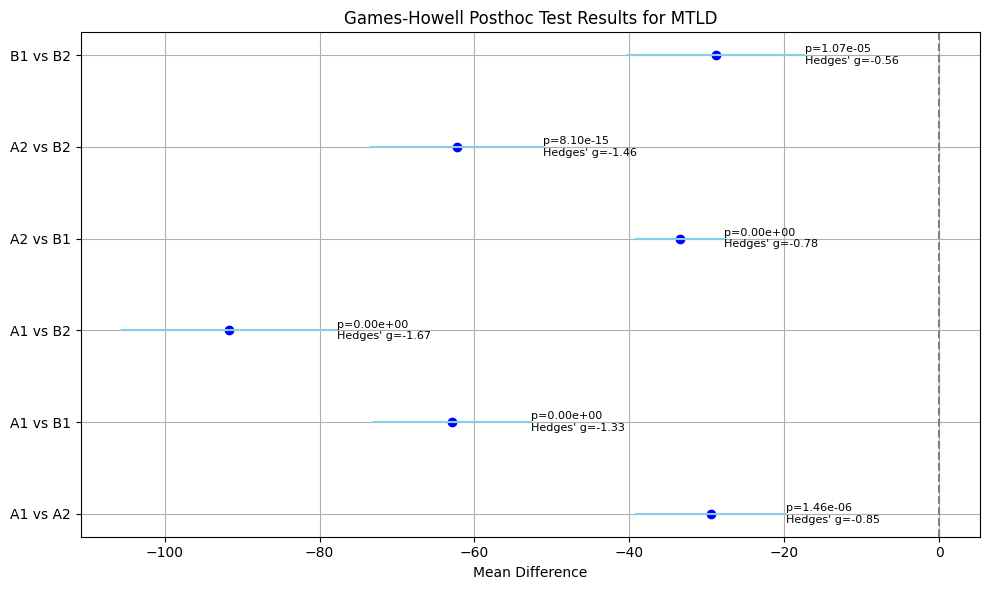

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Определение z_score
z_score = 1.96

# Ваши результаты для HD-D
games_howell_result_hd = pd.DataFrame({
    'A': ['A1', 'A1', 'A1', 'A2', 'A2', 'B1'],
    'B': ['A2', 'B1', 'B2', 'B1', 'B2', 'B2'],
    'mean(A)': [0.864188, 0.864188, 0.864188, 0.904047, 0.904047, 0.922076],
    'mean(B)': [0.904047, 0.922076, 0.929270, 0.922076, 0.929270, 0.929270],
    'diff': [-0.039860, -0.057888, -0.065083, -0.018029, -0.025223, -0.007195],
    'se': [0.007340, 0.007300, 0.007557, 0.001961, 0.002768, 0.002660],
    'T': [-5.430593, -7.929875, -8.612614, -9.192034, -9.113506, -2.704433],
    'df': [42.408328, 41.499495, 47.491716, 815.623350, 236.997696, 207.656888],
    'pval': [1.475554e-05, 4.527449e-09, 1.728367e-10, 0.000000e+00, 0.000000e+00, 3.693495e-02],
    'hedges': [-1.262861, -1.987232, -2.032049, -0.632920, -0.868496, -0.265907]
})

# Ваши результаты для MTLD
games_howell_result_mtld = pd.DataFrame({
    'A': ['A1', 'A1', 'A1', 'A2', 'A2', 'B1'],
    'B': ['A2', 'B1', 'B2', 'B1', 'B2', 'B2'],
    'mean(A)': [54.643420, 54.643420, 54.643420, 84.062297, 84.062297, 117.510344],
    'mean(B)': [84.062297, 117.510344, 146.322332, 117.510344, 146.322332, 146.322332],
    'diff': [-29.418878, -62.866924, -91.678912, -33.448047, -62.260035, -28.811988],
    'se': [4.943951, 5.156825, 7.082474, 2.873149, 5.641239, 5.828702],
    'T': [-5.950480, -12.191015, -12.944477, -11.641597, -11.036589, -4.943122],
    'df': [50.823896, 59.973044, 137.483896, 820.594263, 153.608806, 174.104778],
    'pval': [1.462400e-06, 0.000000e+00, 0.000000e+00, 0.000000e+00, 8.104628e-15, 1.065336e-05],
    'hedges': [-0.850894, -1.325520, -1.668283, -0.781555, -1.462919, -0.559694]
})

# Функция для построения диаграмм
def plot_games_howell(games_howell_result, metric_name):
    # Confidence intervals
    conf_intervals = [
        (md - z_score * s, md + z_score * s) for md, s in zip(games_howell_result['diff'], games_howell_result['se'])
    ]

    # Plotting
    plt.figure(figsize=(10, 6))
    for i, (group, ci, p, h) in enumerate(
        zip(games_howell_result['A'] + ' vs ' + games_howell_result['B'], conf_intervals, games_howell_result['pval'], games_howell_result['hedges'])
    ):
        plt.plot(ci, [i, i], color="skyblue")
        plt.scatter(games_howell_result['diff'].iloc[i], i, color="blue")
        plt.text(ci[1] + 0.005, i, f"p={p:.2e}\nHedges' g={h:.2f}", va='center', ha='left', fontsize=8)  # Изменено расположение текста

    # Formatting
    plt.yticks(range(len(games_howell_result)), games_howell_result['A'] + ' vs ' + games_howell_result['B'])
    plt.axvline(0, color='grey', linestyle='--')
    plt.xlabel("Mean Difference")
    plt.title(f"Games-Howell Posthoc Test Results for {metric_name}")
    plt.grid(True)
    plt.tight_layout()  # Улучшение композиции графика
    plt.show()

# Построение диаграммы для HD-D
plot_games_howell(games_howell_result_hd, 'HD-D')

# Построение диаграммы для MTLD
plot_games_howell(games_howell_result_mtld, 'MTLD')